In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable, Mapping
from sklearn import datasets
from sklearn.model_selection import train_test_split


### Task 1.
 Przygotować funkcję get_dataset(name: str) -> pd.DataFrame, która zwróci ramkę danych z wczytanym zbiorem danych dostępnym w pakiecie Scikit-learn. Jako nazwę można przyjąć dowolny identyfikator, np. alias w adresie URL prowadzącym do szczegółów zbioru: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset (alias jest dostępny po znaku #).

In [70]:
_LOADER_REGISTRY: Mapping[str, Callable[..., object]] = {
    "breast-cancer-wisconsin-diagnostic": datasets.load_breast_cancer,
    "diabetes-dataset": datasets.load_diabetes,
    "iris-dataset": datasets.load_iris,
    "wine-dataset": datasets.load_wine,
    "digits-dataset": datasets.load_digits,
    "breast_cancer": datasets.load_breast_cancer,
    "diabetes": datasets.load_diabetes,
    "iris": datasets.load_iris,
    "wine": datasets.load_wine,
    "digits": datasets.load_digits,
    "california-housing-dataset": datasets.fetch_california_housing,
}

In [71]:
def get_dataset(name:str, loader_registry = _LOADER_REGISTRY) -> pd.DataFrame:

     if not isinstance(name, str) or not name.strip():
        raise ValueError(f"Name must be a string, {type(name)} provided")

     name = name.strip().lower()
     loader = loader_registry.get(name)
     if loader is None:
         raise KeyError(f"No loader registered for {name}")

     try:
         bundle = loader(as_frame=True)
         df = bundle.frame.copy()
         if "target" not in df.columns:
            df["target"] = bundle.target
     except TypeError:
        bundle = loader()
        df = pd.DataFrame(bundle.data, columns=bundle.feature_names)
        df["target"] = bundle.target

     target_names = getattr(bundle, "target_names", None)
     if target_names is not None:
        try:
            mapping = {i: str(t) for i, t in enumerate(target_names)}
            df["target_name"] = df["target"].map(mapping)
        except Exception as e:
            raise e
     return df


In [72]:
df = get_dataset("breast-cancer-wisconsin-diagnostic")

### Task 2.
Dokonać podziału podzbioru treningowego w stosunku 80%:20% przeznaczając 20% na podzbiór walidacyjny, gdzie pozostałe 80% nadal będzie stanowiło podzbiór treningowy, lecz okrojony.



In [24]:
x = df.drop(columns=["target"])
y = df["target"]

In [25]:
x_train_full, x_test, y_train_full, y_test = train_test_split(
    x, y,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=y,
)

x_train_reduced, x_valid, y_train_reduced, y_valid = train_test_split(
    x_train_full, y_train_full,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=y_train_full,
)

### Task 3.
Dla przeprowadzonych podziałów metodą prostą oraz warstwową (dla każdego podziału) przygotować histogram prezentujący rozkład liczebności wartości atrybutu decyzyjnego zarówno w podzbiorze treningowym, jak i testowym.



In [60]:
def plot_hist(vals, title, ticks = False):
    plt.figure()
    bins = np.arange(int(vals.min()), int(vals.max()) + 2) - 0.5
    plt.hist(vals, bins=bins, rwidth=0.8, color="magenta")
    if ticks:
        plt.xticks([0, 1], ["class 0", "class 1"])
    plt.xlabel("target")
    plt.ylabel("count")
    plt.title(title)
    plt.tight_layout()

In [61]:
x_tr_simple, x_te_simple, y_tr_simple, y_te_simple = train_test_split(
    x, y,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

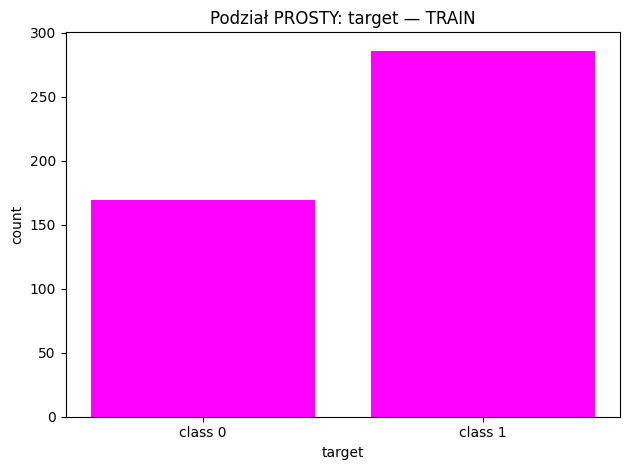

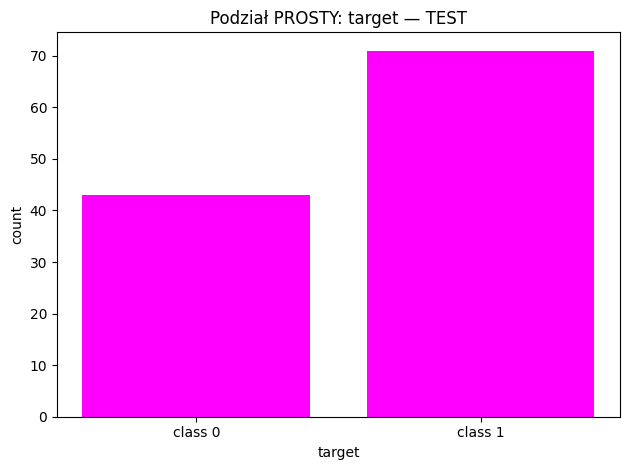

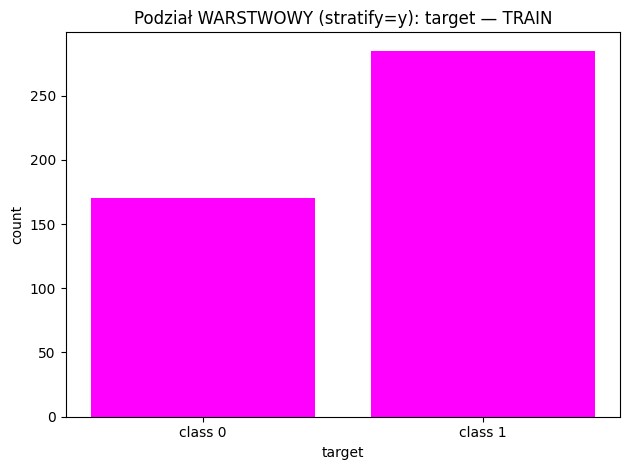

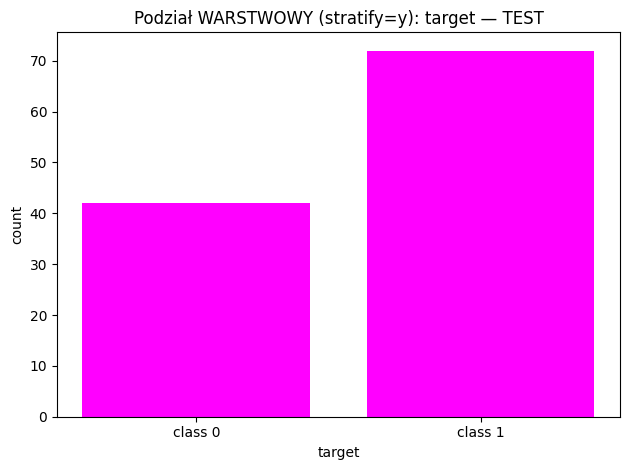

In [62]:
plot_hist(y_tr_simple, "Podział PROSTY: target — TRAIN", ticks=True)
plot_hist(y_te_simple, "Podział PROSTY: target — TEST", ticks=True)

plot_hist(y_train_full, "Podział WARSTWOWY (stratify=y): target — TRAIN", ticks=True)
plot_hist(y_test, "Podział WARSTWOWY (stratify=y): target — TEST", ticks=True)

### Task 4.
Dokonać podziału oryginalnego zbioru danych metodą warstwową względem innego atrybutu (obecnego w pierwotnej wersji zbioru). Jakiego atrybutu i dlaczego warto użyć? Dopuszczalne są niewielkie i uzasadnione zmiany wartości atrybutu stanowiącego źródło proporcji podziału.

In [50]:
attr = "mean radius"
n_bins = 10
bins = pd.qcut(df[attr], q=n_bins, labels=False, duplicates="drop")

`mean radius`  odzwierciedla rozmiar zmiany — klinicznie istotny czynnik, skorelowany ze złośliwością guza.

Stratyfikacja względem tego atrybutu gwarantuje, że w zbiorach treningowym i testowym zostaną zachowane podobne proporcje grup o różnych rozmiarach — model nie będzie uczył się wyłącznie na „małych” lub „dużych” guzach.

In [63]:
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(
    x, y,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=bins,
)

In [64]:
train_bins = pd.qcut(df.loc[x_train_a.index, attr], q=n_bins, labels=False, duplicates="drop")
test_bins  = pd.qcut(df.loc[x_test_a.index,  attr], q=n_bins, labels=False, duplicates="drop")

print("Rozkład koszyków w train:\n", train_bins.value_counts(normalize=True).sort_index())
print("\nRozkład koszyków w test:\n",  test_bins.value_counts(normalize=True).sort_index())

Rozkład koszyków w train:
 mean radius
0    0.101099
1    0.098901
2    0.101099
3    0.101099
4    0.098901
5    0.098901
6    0.098901
7    0.101099
8    0.101099
9    0.098901
Name: proportion, dtype: float64

Rozkład koszyków w test:
 mean radius
0    0.105263
1    0.096491
2    0.096491
3    0.105263
4    0.096491
5    0.096491
6    0.105263
7    0.096491
8    0.096491
9    0.105263
Name: proportion, dtype: float64


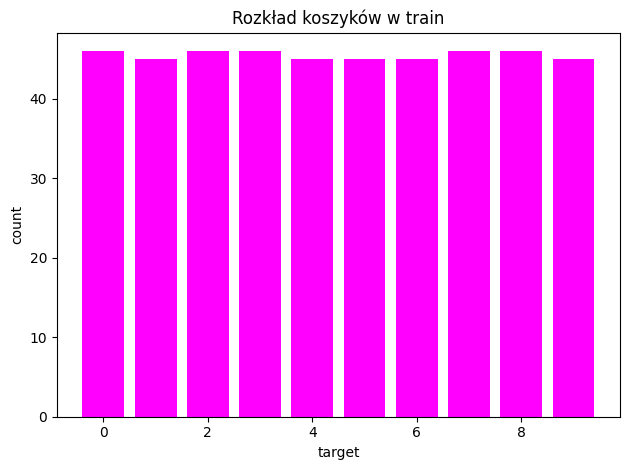

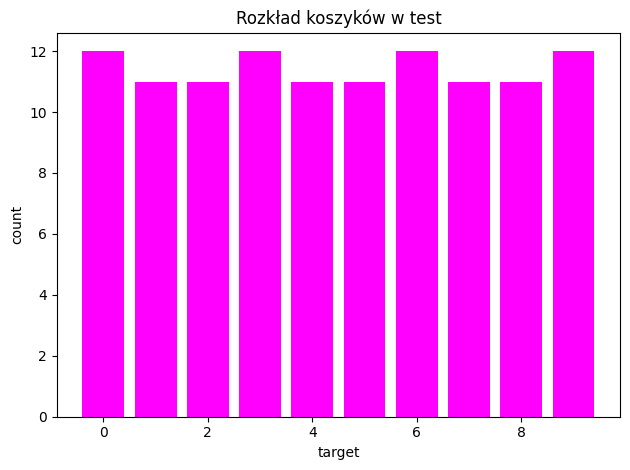

In [65]:
plot_hist(train_bins, "Rozkład koszyków w train")
plot_hist(test_bins, "Rozkład koszyków w test")